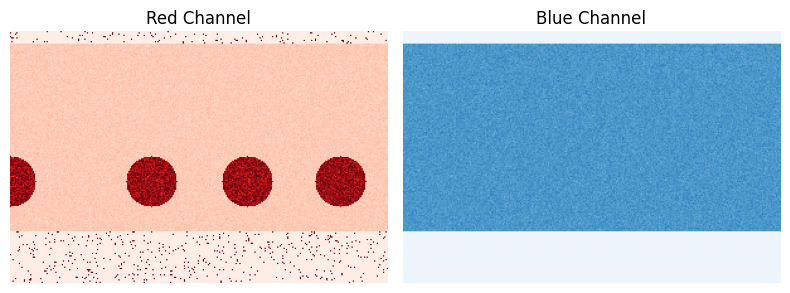

In [57]:
import numpy as np
from typing import Dict, Tuple, List, Optional, Sequence, Union

def _apply_salt_pepper(
    img: np.ndarray,
    *,
    rng: np.random.Generator,
    amount: float = 0.01,
    salt_vs_pepper: float = 0.5,
    mask: Optional[np.ndarray] = None
) -> np.ndarray:
    if amount <= 0:
        return img
    h, w = img.shape
    n_pixels = h * w
    k = int(round(amount * n_pixels))
    if k <= 0:
        return img

    if mask is not None:
        coords = np.argwhere(mask)
        if len(coords) == 0:
            return img
        idx = rng.choice(len(coords), size=min(k, len(coords)), replace=False)
        sel = coords[idx]
    else:
        ys = rng.integers(0, h, size=k)
        xs = rng.integers(0, w, size=k)
        sel = np.stack([ys, xs], axis=1)

    k_salt = int(round(salt_vs_pepper * len(sel)))
    salt_idx = sel[:k_salt]
    pepper_idx = sel[k_salt:]

    if len(salt_idx):
        img[salt_idx[:, 0], salt_idx[:, 1]] = 1.0
    if len(pepper_idx):
        img[pepper_idx[:, 0], pepper_idx[:, 1]] = 0.0
    return img


def _apply_speckle(
    img: np.ndarray,
    *,
    rng: np.random.Generator,
    var: float = 0.0025,  # std^2; default std≈0.05
    mask: Optional[np.ndarray] = None
) -> np.ndarray:
    if var <= 0:
        return img
    std = float(np.sqrt(var))
    if mask is None:
        noise = rng.normal(0.0, std, size=img.shape).astype(img.dtype)
        img = img * (1.0 + noise)
    else:
        noise = rng.normal(0.0, std, size=img.shape).astype(img.dtype)
        img = img.copy()
        img[mask] = img[mask] * (1.0 + noise[mask])
    return np.clip(img, 0.0, 1.0)


def _resolve_noise_for_channel(
    noise_params: Dict[str, object],
    channel_key: str
) -> Dict[str, object]:
    # Start with global params, then override with per-channel dict if present.
    chan: Dict[str, object] = {}
    chan.update(noise_params)  # shallow copy of globals
    if channel_key in noise_params and isinstance(noise_params[channel_key], dict):
        chan.update(noise_params[channel_key])
    return chan


def _apply_noise_layer(
    red: np.ndarray,
    blue: np.ndarray,
    *,
    layer: Dict[str, object],
    tissue_mask: np.ndarray,
    background_mask: np.ndarray,
    crypt_mask: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, Dict[str, object]]:
    """Apply one noise layer configuration to red & blue channels.

    Returns updated (red, blue, summary_dict).
    """
    # RNG for this layer (if seed omitted, use random seed via None -> independent reproducibility if user supplies seeds)
    seed = layer.get("seed", None)
    rng = np.random.default_rng(seed)

    def region_mask(which: str) -> Optional[np.ndarray]:
        if which == "tissue":
            return tissue_mask
        elif which == "background":
            return background_mask
        elif which == "crypts":
            return crypt_mask
        else:
            return None  # all

    # RED
    red_cfg = _resolve_noise_for_channel(layer, "red")
    red_mode = str(red_cfg.get("mode", "none")).lower()
    red_region = str(red_cfg.get("region", "all")).lower()
    red_mask = region_mask(red_region)

    if red_mode == "salt_pepper":
        red = _apply_salt_pepper(
            red, rng=rng,
            amount=float(red_cfg.get("amount", 0.01)),
            salt_vs_pepper=float(red_cfg.get("salt_vs_pepper", 0.5)),
            mask=red_mask
        )
    elif red_mode == "speckle":
        red = _apply_speckle(
            red, rng=rng,
            var=float(red_cfg.get("speckle_var", 0.0025)),
            mask=red_mask
        )

    # BLUE
    blue_cfg = _resolve_noise_for_channel(layer, "blue")
    blue_mode = str(blue_cfg.get("mode", "none")).lower()
    blue_region = str(blue_cfg.get("region", "all")).lower()
    blue_mask = region_mask(blue_region)

    if blue_mode == "salt_pepper":
        blue = _apply_salt_pepper(
            blue, rng=rng,
            amount=float(blue_cfg.get("amount", 0.01)),
            salt_vs_pepper=float(blue_cfg.get("salt_vs_pepper", 0.5)),
            mask=blue_mask
        )
    elif blue_mode == "speckle":
        blue = _apply_speckle(
            blue, rng=rng,
            var=float(blue_cfg.get("speckle_var", 0.0025)),
            mask=blue_mask
        )

    summary = {
        "seed": seed,
        "red": {
            "mode": red_mode,
            "region": red_region,
        },
        "blue": {
            "mode": blue_mode,
            "region": blue_region,
        }
    }
    return red, blue, summary


def generate_test_crypts(
    *,
    image_size: Tuple[int, int] = (100, 100),
    num_crypts: Optional[int] = None,
    line_height_frac: float = 0.6,
    positions_override: Optional[Dict[int, float]] = None,
    # size controls
    blob_size_px: Optional[int] = None,   # diameter; overrides radius_px if provided
    radius_px: Optional[int] = None,      # radius; ignored if blob_size_px is given
    intensities: Optional[Dict[str, float]] = None,
    noise_params: Optional[Union[Dict[str, object], Sequence[Dict[str, object]]]] = None,
    # NEW: tissue band control (in multiples of crypt radius)
    tissue_top_offset_r: Optional[float] = None,
    tissue_bottom_offset_r: Optional[float] = None,
    dtype=np.float32
) -> Tuple[np.ndarray, np.ndarray, Dict[str, object]]:
    """
    Generate paired test images (red, blue) from a horizontal-line tissue rule with crypts,
    and optionally add one or multiple noise layers.

    Parameters
    ----------
    image_size : (H, W)
    num_crypts : inferred if None
    line_height_frac : float in [0,1]; vertical position of crypt centers
    positions_override : optional dict mapping crypt index -> custom fractional x-position *within [0, num_crypts]*
    blob_size_px / radius_px : shape controls (blob_size_px takes precedence)
    intensities : override default intensity dictionary
    noise_params : dict OR list of dicts; each dict is a noise layer (see below)
    tissue_top_offset_r : optional (float); how many radii ABOVE the crypt center line the tissue band extends.
        If None, legacy behaviour is used (top bound independent of y_line: y0 = floor(r/2)).
    tissue_bottom_offset_r : optional (float); how many radii BELOW the crypt center line the tissue band extends.
        If None, legacy behaviour is used (bottom at y_line + 1.5*r).

    Noise layer/global keys (each layer):
      - mode: "speckle" | "salt_pepper" | "none"  (default "none")
      - region: "all" | "tissue" | "background" | "crypts"  (default "all")
      - seed: int or None  (default None)
      - speckle_var: variance for multiplicative speckle (default 0.0025)
      - amount: fraction for salt & pepper (default 0.01)
      - salt_vs_pepper: salt ratio (default 0.5)
      - per-channel overrides via keys 'red' / 'blue'

    Multiple noise layers example:
        noise_params = [
            {"mode": "speckle", "speckle_var": 0.004, "region": "tissue", "seed": 0},
            {"mode": "salt_pepper", "amount": 0.01, "region": "crypts", "seed": 1},
        ]

    Returns
    -------
    red, blue, meta  (meta contains geometry + applied noise summaries)
    """
    H, W = image_size
    assert H > 0 and W > 0, "image_size must be positive"
    assert 0.0 <= line_height_frac <= 1.0, "line_height_frac must be in [0, 1]"

    # Intensities with defaults
    I = {
        "background":     0.05,
        "red_tissue":     0.20,
        "blue_tissue":    0.50,
        "crypt_red":      0.80,
        "crypt_blue_sub": 0.00,
    }
    if intensities:
        I.update(intensities)
    for k in list(I.keys()):
        if k != "crypt_blue_sub":
            I[k] = float(np.clip(I[k], 0.0, 1.0))

    # Resolve radius/count
    source_of_radius = None
    if blob_size_px is not None:
        r = max(1, int(round(blob_size_px / 2)))
        source_of_radius = "blob_size_px"
        if num_crypts is None:
            num_crypts = max(1, int(np.floor(W / (2.5 * r))))
    elif radius_px is not None:
        r = max(1, int(radius_px))
        source_of_radius = "radius_px"
        if num_crypts is None:
            num_crypts = max(1, int(np.floor(W / (2.5 * r))))
    else:
        if num_crypts is None:
            num_crypts = 5
        r = max(1, int(round(W / (2.5 * num_crypts))))
        source_of_radius = "derived_from_num_crypts"

    assert num_crypts >= 1, "num_crypts must be >= 1 after inference"

    # Geometry
    y_line = int(round(line_height_frac * (H - 1)))

    # Legacy behaviour (no offsets provided):
    #   y0 = floor(r/2)
    #   y1 = ceil(y_line + 1.5*r)
    if tissue_top_offset_r is None and tissue_bottom_offset_r is None:
        y0 = int(np.floor(r / 2))
        y1 = int(np.ceil(y_line + 1.5 * r))
        top_mode = "legacy"
    else:
        # If one offset missing, fall back to legacy equivalent for that side
        if tissue_top_offset_r is None:
            tissue_top_offset_r = (y_line - np.floor(r / 2)) / max(r, 1)
        if tissue_bottom_offset_r is None:
            tissue_bottom_offset_r = 1.5
        y0 = int(np.floor(y_line - tissue_top_offset_r * r))
        y1 = int(np.ceil(y_line + tissue_bottom_offset_r * r))
        top_mode = "custom"

    y0 = max(0, y0)
    y1 = min(H, y1)
    if y0 >= y1:  # degenerate; ensure at least one row
        y0 = max(0, min(H - 1, y0))
        y1 = min(H, y0 + 1)

    # Initialize images
    red = np.full((H, W), I["background"], dtype=dtype)
    blue = np.full((H, W), I["background"], dtype=dtype)

    # Tissue band
    tissue_mask = np.zeros((H, W), dtype=bool)
    if y0 < y1:
        red[y0:y1, :] = I["red_tissue"]
        blue[y0:y1, :] = I["blue_tissue"]
        tissue_mask[y0:y1, :] = True

    # Draw crypts & accumulate crypt mask
    yy, xx = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")
    rr2 = r * r
    positions_override = positions_override or {}

    positions_used: List[float] = []
    centers: List[Tuple[int, int]] = []
    crypt_mask = np.zeros((H, W), dtype=bool)

    for i in range(num_crypts):
        default_frac = (i + 0.5) / num_crypts
        if i in positions_override:
            frac = float(positions_override[i]) / num_crypts
        else:
            frac = default_frac

        cx = int(round(frac * W))
        cx = max(0, min(W - 1, cx))
        cy = y_line

        positions_used.append(frac)
        centers.append((cx, cy))

        mask = (xx - cx) ** 2 + (yy - cy) ** 2 <= rr2
        crypt_mask |= mask

        red[mask] = I["crypt_red"]
        if I["crypt_blue_sub"] != 0.0:
            blue[mask] = np.clip(blue[mask] - I["crypt_blue_sub"], 0.0, 1.0)

    background_mask = ~tissue_mask  # everything not in tissue band

    # -------- Optional Noise Injection (supports multiple layers) --------
    noise_layer_summaries: List[Dict[str, object]] = []
    if noise_params:
        if isinstance(noise_params, dict):
            layers: Sequence[Dict[str, object]] = [noise_params]
        else:
            layers = list(noise_params)
        for layer in layers:
            red, blue, summary = _apply_noise_layer(
                red, blue,
                layer=layer,
                tissue_mask=tissue_mask,
                background_mask=background_mask,
                crypt_mask=crypt_mask,
            )
            noise_layer_summaries.append(summary)

    meta = {
        "radius_px": r,
        "radius_source": source_of_radius,
        "y_line": y_line,
        "tissue_y0": y0,
        "tissue_y1": y1,
        "centers": centers,
        "positions_used": positions_used,
        "num_crypts": num_crypts,
        "masks": {
            "tissue": tissue_mask,
            "crypts": crypt_mask,
            "background": background_mask,
        },
        "noise_layers": noise_layer_summaries,
        "tissue_band_mode": top_mode,
        "tissue_top_offset_r": tissue_top_offset_r if top_mode == "custom" else None,
        "tissue_bottom_offset_r": tissue_bottom_offset_r if top_mode == "custom" else None,
    }
    return red.astype(dtype), blue.astype(dtype), meta

# ------------------------------------------------------------------
# Example usage (single layer – backwards compatible)
blob_size_px = 40
# Single noise layer example (commented):
# noise = {"mode": "speckle", "speckle_var": 0.003, "region": "tissue", "seed": 0}
# red, blue, _ = generate_test_crypts(
#     image_size=(200, 300),
#     num_crypts=4,
#     blob_size_px=blob_size_px,
#     line_height_frac=0.6,
#     positions_override={0: 0},
#     intensities={
#         "background": 0.1,
#         "red_tissue": 0.3,
#         "blue_tissue": 0.6,
#         "crypt_red": 0.9,
#         "crypt_blue_sub": 0,
#     },
#     noise_params=noise,
#     dtype=np.float32
# )

# Example usage (multiple layers + custom tissue offsets)
multi_noise = [
    {"mode": "speckle", "speckle_var": 0.004, "region": "tissue", "seed": 0},
    {"mode": "salt_pepper", "amount": 0.02, "region": "background", "seed": 1, "blue": {"mode": "none"}},
    {"mode": "speckle", "speckle_var": 0.01, "region": "tissue", "seed": 1, "blue": {"mode": "none"}},
    {},  # effectively no-op layer (mode defaults to none)
]
red, blue, _ = generate_test_crypts(
    image_size=(200, 300),
    num_crypts=4,
    blob_size_px=blob_size_px,
    line_height_frac=0.6,
    positions_override={0: 0},
    intensities={
        "background": 0.05,
        "red_tissue": 0.2,
        "blue_tissue": 0.6,
        "crypt_red": 0.9,
        "crypt_blue_sub": 0,
    },
    noise_params=multi_noise,
    #tissue_top_offset_r=1.2,      # extend 1.2 radii above crypt center
    tissue_bottom_offset_r=2.0,   # extend 2.0 radii below crypt center
    dtype=np.float32
)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(red, cmap='Reds', vmin=0, vmax=1)
axs[0].set_title('Red Channel')
axs[0].axis('off')
axs[1].imshow(blue, cmap='Blues', vmin=0, vmax=1)
axs[1].set_title('Blue Channel')
axs[1].axis('off')
plt.tight_layout()
plt.show()


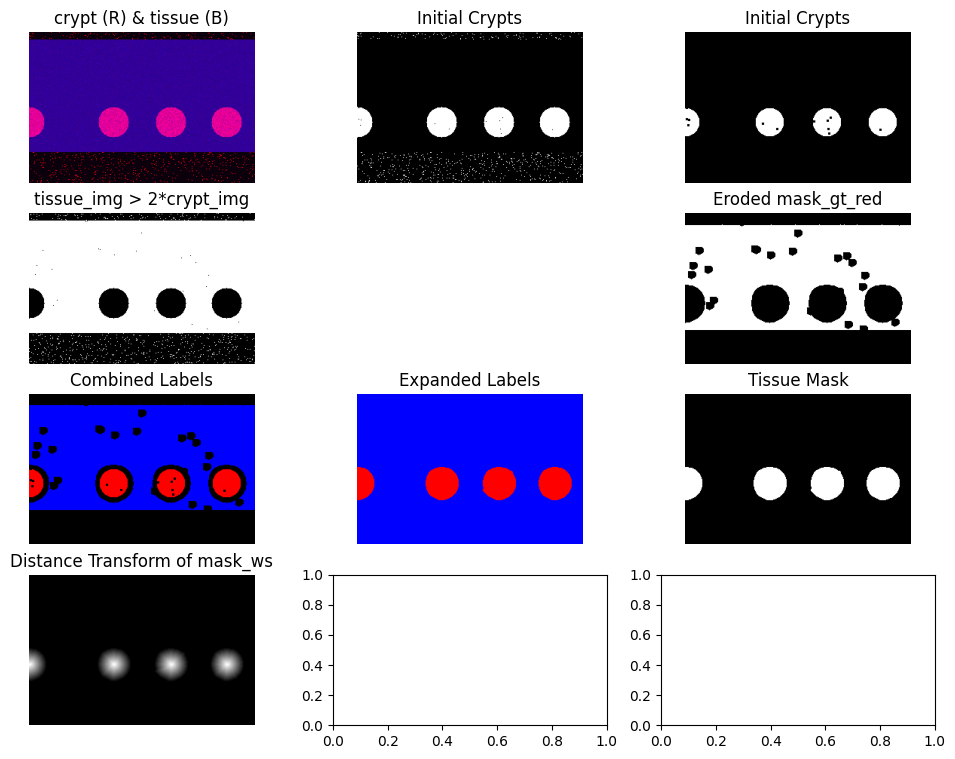

In [ ]:
import cv2

from skimage import morphology
from skimage.segmentation import expand_labels, watershed, find_boundaries
from scipy.ndimage import label as ndi_label, distance_transform_edt
from skimage.feature import peak_local_max
import scipy.ndimage as ndi
from skimage.color import label2rgb as label_to_rgb
def minmax01(x, eps=1e-12):
    x = x.astype(float, copy=False)
    lo = np.min(x)
    hi = np.max(x)
    return (x - lo) / max(hi - lo, eps)

crypt_img, tissue_img = red, blue
# identify initial crypt regions``
fig2, ax2 = plt.subplots(4, 3, figsize=(4*3, 3*3))
rgb = np.zeros((crypt_img.shape[0], crypt_img.shape[1], 3), dtype=crypt_img.dtype)
rgb[..., 0] = crypt_img  # red channel
rgb[..., 1] = 0          # green channel
rgb[..., 2] = tissue_img # blue channel
ax2[0,0].imshow(rgb, vmin=0, vmax=1)
ax2[0,0].set_title("crypt (R) & tissue (B)")
ax2[0,0].axis("off")

# initial detect crypts
initial_crypts = morphology.remove_small_objects(
    morphology.binary_erosion(
        (crypt_img > tissue_img),
        footprint=np.ones((3, 3))
    ),
    min_size=(3.14 * (blob_size_px/2)**2)//4
    )
## plot the intial crypts before cleaning
ax2[0,1].imshow(crypt_img > tissue_img, cmap='gray')
ax2[0,1].set_title("Initial Crypts")
ax2[0,1].axis("off")

## plot initial crypts
ax2[0,2].imshow(initial_crypts, cmap='gray')
ax2[0,2].set_title("Initial Crypts")
ax2[0,2].axis("off")



# Secondary mask 

# Erode the secondary mask (exact notebook parameters)
erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6))
mask_gt_red_eroded = cv2.erode(
    ((tissue_img > 2*crypt_img).astype(np.uint8) * 255),
    erosion_kernel,
    iterations=2
    ).astype(bool)
## plot  tissue_img > 2*crypt_img
ax2[1,0].imshow(tissue_img > 2*crypt_img, cmap='gray')
ax2[1,0].set_title("tissue_img > 2*crypt_img")
ax2[1,0].axis("off")
## plot add spacer
ax2[1,1].axis("off")
## plot eroded mask
ax2[1,2].imshow(mask_gt_red_eroded, cmap='gray')
ax2[1,2].set_title("Eroded mask_gt_red")
ax2[1,2].axis("off")

# set up labels
combined_labels = np.zeros_like(initial_crypts, dtype=int)
combined_labels[mask_gt_red_eroded] = 2
combined_labels[initial_crypts] = 1
## plot combined labels
ax2[2,0].imshow(label_to_rgb(combined_labels), cmap='gray')
ax2[2,0].set_title("Combined Labels")
ax2[2,0].axis("off")



# Expand labels (exact notebook distance=100)
expanded_labels = expand_labels(combined_labels, distance=blob_size_px*3)
## plot expanded labels
ax2[2,1].imshow(label_to_rgb(expanded_labels), cmap='gray')
ax2[2,1].set_title("Expanded Labels")
ax2[2,1].axis("off")
# Markers from diff_r (exact notebook logic)
tissue_mask = expanded_labels != 1
## plot tissue_mask
ax2[2,2].imshow(tissue_mask, cmap='gray')
ax2[2,2].set_title("Tissue Mask")
ax2[2,2].axis("off")

#labeled_diff_r, _ = ndi_label(diff_r != 0)

# Reworked markers array 


# Watershed mask (exact notebook logic)
mask_ws = tissue_mask
coords = peak_local_max(distance_transform_edt(~mask_ws), min_distance=blob_size_px//2, exclude_border=False)
## plot distance_transform_edt(mask_ws)
ax2[3,0].imshow(distance_transform_edt(mask_ws), cmap='gray')
ax2[3,0].set_title("Distance Transform of mask_ws")
ax2[3,0].axis("off")


elevation = (
    minmax01(distance_transform_edt(combined_labels == 2))
    - minmax01(distance_transform_edt(combined_labels == 1))
)


mask = np.zeros(mask_ws.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
ws_labels = watershed(elevation, markers=markers, mask=mask_ws)

# Plot results
plt.show()